In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
from graph_generator import kronecker_random_graph, P_peri
from cascade import generate_cascade
from matplotlib import pyplot as plt

In [32]:
def run_simulation(k=8, P=P_peri, n_edges=512):
    g = kronecker_random_graph(k, P, directed=False, n_edges=512)
    cascade = generate_cascade(g)
    source = min(cascade, key=lambda k: cascade[k])
    source_inflected_nbrs = list(filter(lambda k: k in cascade, g.neighbors(source)))
    source_uninflected_nbrs = list(filter(lambda k: k not in cascade, g.neighbors(source)))
    
    g.remove_edges_from(g.selfloop_edges())
    core_numbers = nx.core_number(g)
    
    return {
        '#infected': len(source_inflected_nbrs),
        '#uninfected': len(source_uninflected_nbrs),
        'degree': len(g.neighbors(source)),
        '#cascade': len(cascade),
        'core number': core_numbers[source],
        'infected times': list(filter(None, [cascade.get(n) for n in g.neighbors(source)]))
    }


In [33]:
from joblib import Parallel, delayed
rows = Parallel(n_jobs=8)(delayed(run_simulation)() for _ in range(int(1e3)))

In [34]:
import pandas as pd
df = pd.DataFrame.from_records(rows)

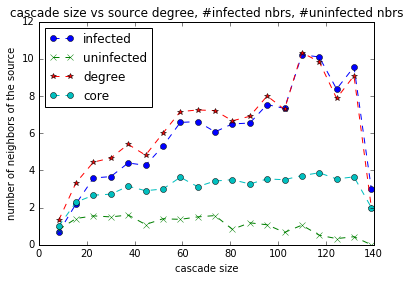

In [26]:
from scipy.stats import binned_statistic
bins = np.linspace(df['#cascade'].min(), df['#cascade'].max(), num=20)
values, bin_edges, _ = binned_statistic(df['#cascade'], df['#infected'], bins=bins, statistic='mean')
plt.plot(bin_edges[1:], values, '--o')


values, bin_edges, _ = binned_statistic(df['#cascade'], df['#uninfected'], bins=bins, statistic='mean')
plt.hold(True)
plt.plot(bin_edges[1:], values, '--x')

values, bin_edges, _ = binned_statistic(df['#cascade'], df['degree'], bins=bins, statistic='mean')
plt.hold(True)
plt.plot(bin_edges[1:], values, '--*')

values, bin_edges, _ = binned_statistic(df['#cascade'], df['core number'], bins=bins, statistic='mean')
plt.hold(True)
plt.plot(bin_edges[1:], values, '--o')


plt.xlabel('cascade size')
plt.ylabel('number of neighbors of the source')

plt.legend(['infected', 'uninfected', 'degree', 'core'], loc='upper left')
plt.title('cascade size vs source degree, #infected nbrs, #uninfected nbrs')

In [39]:
df = df[df['infected times'].apply(len) > 0]

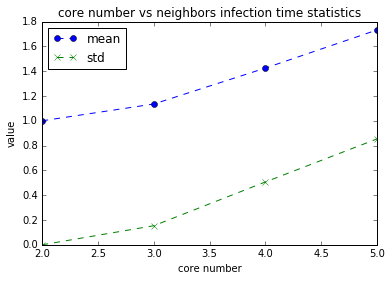

In [52]:
means = df['infected times'].apply(np.mean)
stds = df['infected times'].apply(np.std)
cores = df['core number']

plt.clf()

bins = np.linspace(cores.min(), cores.max(), num=5)
values, bin_edges, _ = binned_statistic(cores, means, bins=bins, statistic='mean')
plt.plot(bin_edges[1:], values, '--o')

values, bin_edges, _ = binned_statistic(cores, stds, bins=bins, statistic='mean')
plt.plot(bin_edges[1:], values, '--x')

plt.legend(['mean', 'std'], loc='upper left')
plt.xlabel('core number')
plt.ylabel('value')
plt.title('core number vs neighbors infection time statistics')